In [47]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")

In [48]:
# Morphological traits 1 ~ 16
old_df = pd.read_csv('herb_data.csv')
old_df = old_df[old_df["Putative_spp"] != "Quercus sp."]
old_df = old_df[old_df["Putative_spp"] != "Quercus buckleyi"]
#save this new dataframe to a new csv file
old_df.to_csv("herb_data_filtered.csv", index=False)

In [49]:
df = pd.read_csv('herb_data_filtered.csv')

df["spp"] = df["Putative_spp"].apply(lambda x: "A" if x == "Quercus shumardii var. acerifolia" else "S or R")

feature_list_1 =["Lobe.number","BW","TLIW","LLL","LSR","LLDW","LLIW"]
feature_list_2 = ["Latitude", "Longitude","LLL.LLLDW","BL.BW"]

data = df[feature_list_1]

#sample a random row from the data
test_data = data.sample(1)

# Log-transform the data
transformer = FunctionTransformer(np.log, validate=True)
data_transformed = transformer.fit_transform(data)

# Standardize the data (important for PCA)
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data_transformed)

In [50]:
spectral = SpectralClustering(n_clusters=2, random_state=0)
cluster_labels = spectral.fit_predict(data_standardized)

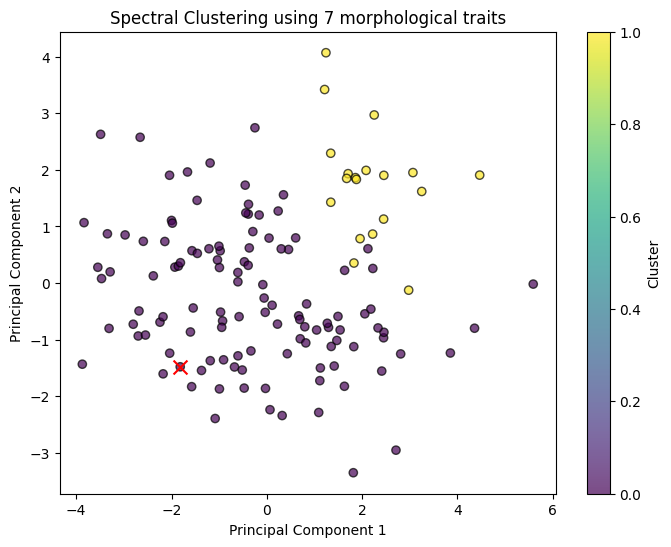

In [51]:
# Perform PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_standardized)

# Plot the PCA-transformed data
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=cluster_labels, cmap='viridis', edgecolor='k', alpha=0.7)
#plot the test data
test_data_standardized = scaler.transform(transformer.transform(test_data))
test_data_pca = pca.transform(test_data_standardized)
plt.scatter(test_data_pca[:, 0], test_data_pca[:, 1], c='r', marker='x', s=100, label='Test Data')
plt.title('Spectral Clustering using 7 morphological traits')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [52]:
#collect the data of group 1 as a set, and group 2 as another set
group1 = data[cluster_labels == 0]
group2 = data[cluster_labels == 1]
test_point = scaler.transform(transformer.transform(test_data))
knn = KNeighborsClassifier()
knn.fit(data_standardized, cluster_labels)
test_point_cluster = knn.predict(test_point)[0]

In [53]:
df["Longitude"] = df["Longitude"].abs()
loc_data = df[feature_list_2].dropna()

# Log-transform the data
transformer_2 = FunctionTransformer(np.log, validate=True)
loc_data_transformed = transformer_2.fit_transform(loc_data)
scaler_2 = StandardScaler()
loc_data_standardized = scaler_2.fit_transform(loc_data_transformed)

In [54]:
loc_spec = SpectralClustering(n_clusters=2, random_state=0)
loc_cluster_labels = loc_spec.fit_predict(loc_data_standardized)
loc_knn = KNeighborsClassifier()
loc_knn.fit(loc_data_standardized, loc_cluster_labels)

KNeighborsClassifier()

In [55]:
#collect the data of group 1 as a set, and group 2 as another set
loc_group_a = loc_data_standardized[loc_cluster_labels == 0]
loc_group_b = loc_data_standardized[loc_cluster_labels == 1]

#generate group centroids
loc_group_a_centroid = loc_group_a.mean(axis=0).reshape(1, -1)
loc_group_b_centroid = loc_group_b.mean(axis=0).reshape(1, -1)

#compare size of group 1 and group 2
loc_group_a_size = len(loc_group_a)
loc_group_b_size = len(loc_group_b)
print("loc_group A (Purple) size: ", loc_group_a_size)
print("loc_group B (Yellow) size: ", loc_group_b_size)
test_data_ground_truth = loc_data_standardized[test_data.index[0]].reshape(1, -1)
distance_from_group_a = np.linalg.norm(test_data_ground_truth - loc_group_a_centroid)
distance_from_group_b = np.linalg.norm(test_data_ground_truth - loc_group_b_centroid)
print("Distance from group A (Purple) centroid: ", distance_from_group_a)
print("Distance from group B (Yellow) centroid: ", distance_from_group_b)

loc_group A (Purple) size:  117
loc_group B (Yellow) size:  18
Distance from group A (Purple) centroid:  1.26104596495946
Distance from group B (Yellow) centroid:  2.746742088599186


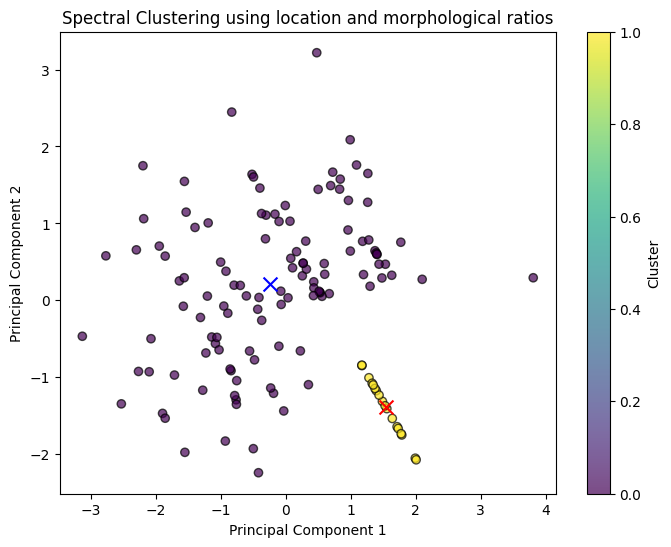

In [60]:
#visualize the data
# plt.figure(figsize=(12, 6))
# plt.scatter(loc_data["Latitude"], loc_data["Longitude"], c=loc_cluster_labels, cmap='viridis', edgecolor='k', alpha=0.7)
# plt.scatter(loc_group_a_centroid[0], loc_group_a_centroid[1], c='blue', s=100, marker='x')
# plt.scatter(loc_group_b_centroid[0], loc_group_b_centroid[1], c='black', s=100, marker='x')
# plt.scatter(test_data_ground_truth["Latitude"], test_data_ground_truth["Longitude"], c='red', s=100, marker='x')

# Perform PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(loc_data_standardized)
loc_a_pca = pca.transform(loc_group_a_centroid)
loc_b_pca = pca.transform(loc_group_b_centroid)
test_data_pca = pca.transform(test_data_ground_truth)

species_labels = df['spp']
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data_pca[:, 0], data_pca[:, 1], c=loc_cluster_labels, cmap='viridis', edgecolor='k', alpha=0.7)
plt.scatter(loc_a_pca[:, 0], loc_a_pca[:, 1], c='blue', s=100, marker='x')
plt.scatter(loc_b_pca[:, 0], loc_b_pca[:, 1], c='red', s=100, marker='x')
#plt.scatter(test_data_pca[:, 0], test_data_pca[:, 1], c='red', s=100, marker='x')
plt.title('Spectral Clustering using location and morphological ratios')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [57]:

decision_matrix = np.zeros((2, 2))
for i in range(50):
    supervised_pt = df.sample(1)
    #keep only 16 columns of supervised data
    gmm_pt = supervised_pt[feature_list_1].dropna()
    kmeans_pt = supervised_pt[feature_list_2].dropna()
    pred1 = knn.predict(scaler.transform(transformer.transform(gmm_pt)))
    pred2 = loc_knn.predict(scaler_2.transform(transformer_2.transform(kmeans_pt)))
    decision_matrix[pred1[0]][pred2[0]] += 1

print("Decision matrix: ")
print(decision_matrix)

def decision(matrix):
    max_indices = np.argmax(matrix, axis=1)
    if max_indices[0] == max_indices[1]:
        differences = np.abs(np.diff(matrix, axis=1)).flatten()
        row_with_smaller_difference = np.argmin(differences)
        max_indices[row_with_smaller_difference] = 1 - max_indices[row_with_smaller_difference]
    return max_indices

decision_vector = decision(decision_matrix)
print("Decision vector: ")
print(decision_vector)
        

Decision matrix: 
[[44.  1.]
 [ 0.  5.]]
Decision vector: 
[0 1]


In [58]:
# #only run this cell for accuracy calculation
# score = 0
# k = 100
# accarcies = []

# for l in range(135):
#     print("l: ", l)
#     score = 0
#     for j in range(k):
#         decision_matrix = np.zeros((2, 2))
#         for i in range(l):
#             supervised_pt = df.sample(1)
#             #keep only 16 columns of supervised data
#             pt = supervised_pt[feature_list_1].dropna()
#             loc_pt = supervised_pt[feature_list_2].dropna()
#             pred1 = knn.predict(scaler.transform(transformer.transform(pt)))
#             pred2 = loc_knn.predict(scaler_2.transform(transformer_2.transform(loc_pt)))
#             decision_matrix[pred1[0]][pred2[0]] += 1

#         decision_vector = decision(decision_matrix)
#         if decision_vector[0] == 0 and decision_vector[1] == 1:
#             score = score + 1
        
#     #print("Accuracy: ", score/k)
#     accarcies.append(score/k)

# #plot
# plt.figure(figsize=(8, 6))
# plt.plot(accarcies)
# plt.title('Accuracy for Cluster Association')
# plt.xlabel('Number of supervised data points')
# plt.ylabel('Accuracy')
# plt.show()


# # i=5 accuracy: 0.9994
# # i=10 accuracy: 1.0000

In [59]:
decision_vector = np.array([0,1])
predict_group = 0

test_result = decision_vector[test_point_cluster]
if test_result == 0:
    print("Test point is in group A (Purple)")
else:
    print("Test point is in group B (Yellow)")
    predict_group = 1

actual_closer_group = np.argmin([distance_from_group_a, distance_from_group_b])
print("Distance from group A (Purple) centroid: ", distance_from_group_a)
print("Distance from group B (Yellow) centroid: ", distance_from_group_b)
if predict_group == actual_closer_group:
    print("Close prediction!")
else:
    print("Far prediction!")

Test point is in group A (Purple)
Distance from group A (Purple) centroid:  1.26104596495946
Distance from group B (Yellow) centroid:  2.746742088599186
Close prediction!
